In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import math

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


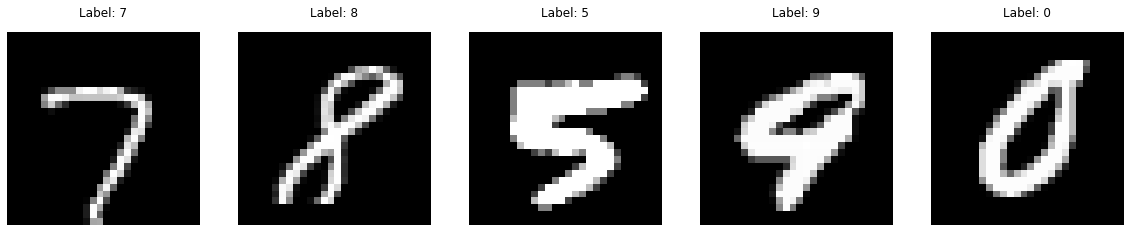

In [ ]:
with np.load('mnist.npz') as npz:
    x_train, y_train, x_test, y_test = [npz[k] for k in ['x_train', 'y_train', 'x_test', 'y_test']]

fig, ax = plt.subplots(figsize=(20, 4),  ncols=5)
for a in ax:
    i = np.random.randint(x_train.shape[0])
    a.matshow(x_train[i], cmap='gray')
    a.set_title(f'Label: {y_train[i]}')
    a.axis('off')
    
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

In [ ]:
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

print(f'x_train shape after reshape: {x_train.shape}')
print(f'x_test shape after reshape: {x_test.shape}')

x_train shape after reshape: (60000, 784)
x_test shape after reshape: (10000, 784)


In [ ]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [ ]:
with tf.device('/device:GPU:0'):
  class LogisticRegression:
    def __init__(
        self,
        neurons,
        lr,
        batch_size
    ):
      self.neurons = neurons
      self.lr = lr
      self.batch_size = batch_size

      self.w = [
                tf.Variable(tf.random.uniform(
                    shape = (neurons[i], neurons[i + 1]),
                    minval = -math.sqrt(6 / (neurons[i] + neurons[i + 1])),
                    maxval = math.sqrt(6 / (neurons[i] + neurons[i + 1])),
                )) for i in range(len(neurons) - 1)
      ]

      self.b = [tf.Variable(tf.zeros(shape = (1, n))) for n in neurons[1::]]
      self.opt = tf.keras.optimizers.Adam(learning_rate = lr)

    def forward(self, x):
      a = x

      for i in range(len(self.w)):
        a = tf.nn.sigmoid(a @ self.w[i] + self.b[i])

      return a
    
    def onehot(self, y):
      y_proc = np.zeros((y.size, 10))
      y_proc[np.arange(y.size), y] = 1
      return y_proc.astype(np.float32)
    
    def get_batch(self, x, y):
      perm = np.random.permutation(x.shape[0])[:self.batch_size]
      return x[perm], y[perm]

    @tf.function
    def loss(self, y_pred, y_true):
      return tf.reduce_mean(-y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred))

    @tf.function
    def train_step(self, x, y):
      with tf.GradientTape() as tape:
        y_pred = self.forward(x)
        j = self.loss(y_pred, y)

      grad = tape.gradient(j, self.w + self.b)
      self.opt.apply_gradients(zip(grad, self.w + self.b))

    def train(self, x, y, steps):
      x_t, y_t = 0, 0
      for i in range(steps):
        x_t, y_t = self.get_batch(x, y)
        self.train_step(x_t, self.onehot(y_t))
      
      return self

    def score(self, x, y):
      y_pred = np.argmax(self.forward(x), axis = -1)
      return (y == y_pred).mean()


In [ ]:
reg = LogisticRegression([784, 512, 10], 1e-2, 1024).train(x_train, y_train, 100)
print(f'Test accuracy: {reg.score(x_test, y_test) * 100}%')

Test accuracy: 90.32%


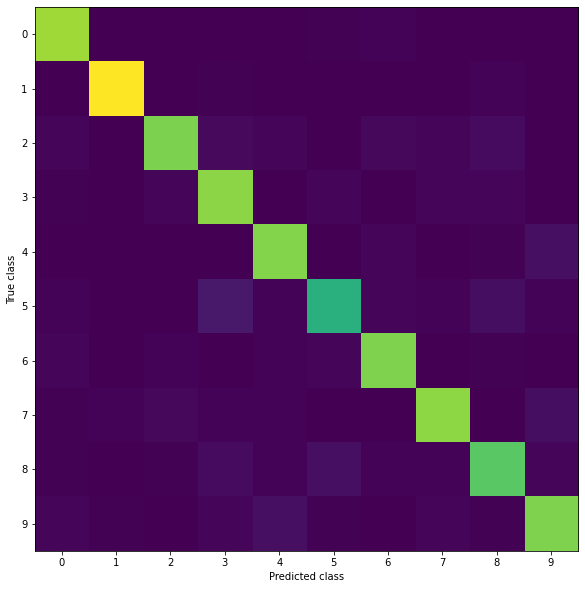

Final accuracy 90.29%


In [ ]:
from sklearn.metrics import confusion_matrix

reg = LogisticRegression([784, 512, 10], 1e-2, 1024).train(x_train, y_train, 100)
y_test_pred = np.argmax(reg.forward(x_test), axis = -1)

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

print(f'Final accuracy {reg.score(x_test, y_test) * 100}%')